# Heavy top - polynomial approximation of degree $1 = j := \text{deg } q$

see thesis -> Numerical experiments -> Degree $j = 1$

This notebook also includes the energy conservation benchmark for $j = 1$.

In [1]:
import ngsolve
if ngsolve.__version__ < "6.2.2405-28": 
    raise Exception("NGSolve too old, pls run 'pip3 install --upgrade --pre ngsolve'")

In [2]:
from ngsolve import *
from netgen.occ import *
import ipywidgets as widgets
from ngsolve.comp import GlobalSpace
from ngsolve.webgui import Draw
from ngsolve.solvers import Newton
from ngsolve.comp import DifferentialSymbol
import numpy as np

## System parameter setup

In [3]:
mass = 15
Jxx = Jzz = 0.234375
Jyy = 0.468750
omega0 = CF( (0,150,-4.61538) )

In [4]:
b = sqrt(3/2 * Jyy/mass)
rho = mass/(4*b*b)     # kg/ m**2

In [5]:
center = Pnt( (0,1,0) )
disk = WorkPlane(Axes((0,1,0), Y)).RectangleC(2*b, 2*b).Face()
shape = Glue ([disk, Segment( (0,0,0), (0,1,0)) ])
shape.vertices.Min(Y).name="A"
mesh = Mesh(OCCGeometry(shape).GenerateMesh(maxh=3))
Draw (mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

## Finite element space setup

In [6]:
# tangent space representation
RBshapes = CF ( ( 1, 0, 0,
                  0, 1, 0,
                  0, 0, 1,
                  y, -x, 0,
                  0, z, -y,
                  -z, 0, x) ).Reshape((6,3)).Compile()
RBspace = GlobalSpace (mesh, order=1, basis = RBshapes)

# basis of (equivalent to) symmetric matrices
SYMshapes = CF ( ( 1, 0, 0, 0, 0, 0, 0, 0, 0,
                   0, 0, 0, 0, 1, 0, 0, 0, 0,
                   0, 0, 0, 0, 0, 0, 0, 0, 1,
                   0, 1, 0, 1, 0, 0, 0, 0, 0,
                   0, 0, 1, 0, 0, 0, 1, 0, 0,
                   0, 0, 0, 0, 0, 1, 0, 1, 0) ).Reshape((6,9)).Compile()
SYMspace = GlobalSpace (mesh, order=1, basis = SYMshapes)

# position space
P1shapes = CF ( ( 1, 0, 0,
                  0, 1, 0,
                  0, 0, 1,
                  x, 0, 0,
                  0, x, 0,
                  0, 0, x,
                  y, 0, 0,
                  0, y, 0,
                  0, 0, y,
                  z, 0, 0,
                  0, z, 0,
                  0, 0, z)).Reshape((12,3)).Compile() # realcompile=True, wait=True)
P1space = GlobalSpace (mesh, order=1, basis = P1shapes)
P1space.AddOperator("dx", VOL, P1shapes.Diff(x))
P1space.AddOperator("dy", VOL, P1shapes.Diff(y))
P1space.AddOperator("dz", VOL, P1shapes.Diff(z))

def MyGrad(gf):
    return CF( (gf.Operator("dx"), gf.Operator("dy"), gf.Operator("dz") )).Reshape((3,3)).trans
def MyGradB(gf):
    return CF( (gf.Operator("dx", BND), gf.Operator("dy", BND), gf.Operator("dz", BND))).Reshape((3,3)).trans
def MyGradBB(gf):
    return CF( (gf.Operator("dx", BBBND), gf.Operator("dy", BBBND), gf.Operator("dz", BBBND))).Reshape((3,3)).trans
              

In [7]:
fesR = NumberSpace(mesh)

fes = P1space * RBspace * fesR**3 * fesR**3
festest = RBspace * RBspace * SYMspace * fesR**3 * fesR**3

gfold = GridFunction(fes)
gf = GridFunction(fes)

# compared to notation from thesis:
# q - initial position, (vold - unused), phatold - initial momentum, (fa1old - unused), (fa2old - unused)
qold, phatold, fa1old, fa2old = gfold.components
gfq, gfphat, gffa1, gffa2 = gf.components

# compared to notation from thesis:
# q - new position, phat - new momentum, fa1 - lagrange parameter mu, fa2 - lagrange parameter lambda
q, phat, fa1, fa2  = fes.TrialFunction()
dq1, dq2, dlagsym, da, daprime = festest.TestFunction()

dvert = DifferentialSymbol(BBBND)

## The equations

In [8]:
force = CF( (0,0,-9.81*rho) )
dpointA = da
dpointAprime = daprime

P0 = CF( (0, 0, 0) )
PA0 = CF( (0, 1, 0))

# time step size
tau = 0.004 * 2**(-2)
  
    
qold.Set ( (x, y, z) )

# rotational part of q at different points in time
Rnew = MyGrad(q)
Rold = MyGradB(qold)
Rmean = 0.5*(Rold+Rnew)

v = (q - qold)/tau

a = BilinearForm(trialspace=fes, testspace=festest)


# What follows are the time stepper equations in the same general order as in the thesis.

a += (((Rnew*phat-rho*v) - tau/2*force) * (Rnew*dq1)) * ds
a += (((rho*v-Rold*phatold) - tau/2*force) * (Rold*dq2)) * ds
# forces from Lagrange parameters, in t_n and t_{n+t}:
a += ( (- tau/2*fa1 ) * (Rnew*dq1)) *dvert("A")
a += ( (- tau/2*fa2 ) * (MyGradBB(qold)*dq2)) *dvert("A")

# constraints and velocity constraints:
a += ((q-P0)*dpointA) * dvert("A")
a += ((phat)*dpointAprime) * dvert("A")

# rotational part of q is orthogonal:
a += InnerProduct (Rnew.trans*Rnew-Id(3), dlagsym) * ds 


In [9]:
# tricky to set initial conditions, since mass matrix alone is singular 
gf.vec[:] = 0
gfphat.Set ( rho*Cross (omega0, CF((x,y,z))) , definedon=mesh.Boundaries(".*") )

qs,dqs = P1space.TnT()
bfset = BilinearForm(qs*dqs*ds + qs.Operator("dy")*dqs.Operator("dy")*ds).Assemble()
lfset = LinearForm(CF((x,y,z))*dqs*ds + CF((0,1,0))*dqs.Operator("dy")*ds).Assemble()
gfq.vec[:] = bfset.mat.Inverse()*lfset.vec

In [10]:
scene = Draw (gf.components[1], mesh, deformation=(gf.components[0]-CF((x,y,z))), center=(0,0,0), radius=1.2)

tw = widgets.Text(value='t = 0')
display(tw)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

Text(value='t = 0')

In [11]:
end_pos = []

t = 0
tt = []
#potential energies
Epott = []
# kinetic energies
Ekint = []
# total energies
Et = []
axt, ayt, azt = [], [], []

while t < 1-1e-10:
    gfold.vec[:] = gf.vec
    Newton(a=a, u=gf, printing=False, maxerr=1e-8)
    scene.Redraw()
    t += tau
    tw.value = "t = {t:.2f}".format(t=t)
    Epot = -Integrate (gfq*force*ds, mesh)
    Ekin = Integrate (2/rho*gfphat*gfphat*ds, mesh)
    tt.append(t)
    Epott.append(Epot)
    Ekint.append(Ekin)
    Et.append(Epot+Ekin)
    axt.append (Integrate(gfq[0]*ds, mesh)/(4*b**2))
    ayt.append (Integrate(gfq[1]*ds, mesh)/(4*b**2))
    azt.append (Integrate(gfq[2]*ds, mesh)/(4*b**2))
    

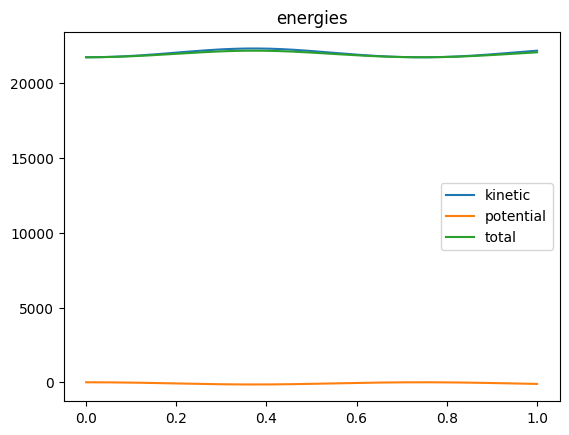

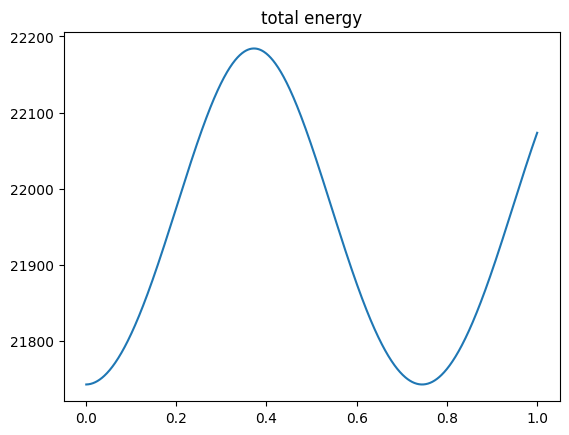

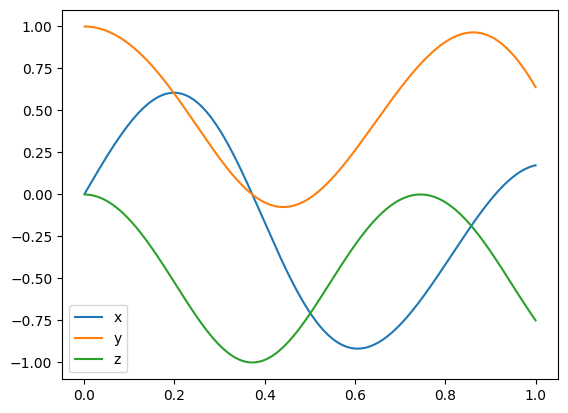

0.1734967234785091 0.6394138065851781 -0.7490319558539986


In [12]:
import matplotlib.pyplot as plt
plt.plot (tt, Ekint, label="kinetic")
plt.plot (tt, Epott, label="potential")
plt.plot (tt, Et, label="total")
plt.legend()
plt.title("energies")
plt.show()

plt.plot (tt, Et)
plt.title("total energy")
plt.show()

plt.plot (tt, axt, label="x")
plt.plot (tt, ayt, label="y")
plt.plot (tt, azt, label="z")
plt.legend()
plt.show()

print (axt[-1], ayt[-1], azt[-1])
